In [1]:
import pandas as pd
import numpy as np
import datetime
from bs4 import BeautifulSoup
import requests as rqs
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy import integrate
import pulp
from IPython.display import clear_output
from time import sleep
from unidecode import unidecode
import math

In [2]:
def single_team(df) :
    if len(df) == 1: # If player played for a single team, do nothing
        return df
    else: # If player has moved, return total stats with last team
        row = df[df['Tm'] == 'TOT'].copy()
        row['Tm'] = [str(df['Tm'].iloc[-1])]
        return row

def multiplier(n, mean, std) :

    if n == 0 : # If there's no game : 0 score prediction
        return 0
    elif n == 1 : # If there's 1 game : no multiplier needed
        return 1
    elif math.isnan(mean) : # If there's 1 game : no multiplier needed
        return 1
    elif math.isnan(std) : # If there's 1 game : no multiplier needed
        return 1

    else : # More than 1 game : multiplier required
        # Define PDF of distribution of Y = max{X1, X2, ..., Xn}, where Xi 〜 N(mean, std^2)
        def max_PDF(y, n, mean, std) :
            f = n * np.exp(- (y - mean)**2 / (2 * std*std)) / np.sqrt(2 * np.pi * std*std) * (0.5 + 0.5 * erf((y - mean) / np.sqrt(2 * std*std))) ** (n - 1)
            return f
        # Calculte the mean of the distribution of the max
        E_max = round(integrate.quad(lambda x: x * max_PDF(x, n, mean, std), -np.inf, np.inf)[0], 3)

        # Calculate the value of the score multiplier
        if mean == 0 :
            mean = 1
            
        return E_max / mean

def SoRareScore(df):

    df = df.apply(pd.to_numeric, errors = 'ignore')
    scores = []
    for pts, reb, ast, blk, stl, tov, fg_3 in zip(df['PTS'], df['TRB'], df['AST'], df['BLK'], df['STL'], df['TOV'], df['3P']) :
        
        score = 0
        if pts not in ['Inactive', 'Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended']:
            
            pts, reb, ast, blk, stl, tov, fg_3 = int(pts), int(reb), int(ast), int(blk), int(stl), int(tov), int(fg_3)

            score = 1 * pts + 1.2 * reb + 1.5 * ast + 3 * blk + 3 * stl + 1 * fg_3 - 2 * tov

            doubles = 0 # Count double-digits stats
            if pts >= 10 :
                doubles += 1
            if reb >= 10 :
                doubles += 1
            if ast >= 10 :
                doubles += 1
            if blk >= 10 :
                doubles += 1
            if stl >= 10 :
                doubles += 1

            if doubles == 2 : # Double-double
                score += 1

            if doubles >= 3 : # Tripe-double
                score += 2
        
        else :
            score = 'dnp'

        scores.append(score)
    return scores

In [3]:
months = ['october', 'november', 'december', 'january', 'february', 'march', 'april']

monthly_schedule_list = []
for month in months:
    url = f'https://www.basketball-reference.com/leagues/NBA_2023_games-{month}.html'
    page = rqs.get(url)
    soup = BeautifulSoup(page.content, 'html')
    while soup.find('tr', class_ = 'thead') is not None :
        soup.find('tr', class_ = 'thead').decompose()

    table = soup.find('table')
    monthly_schedule = pd.read_html(str(table))[0]

    home_tm, away_tm = [], []
    for i, x in enumerate(table.find_all('a', href = True), start = 1):
        if x['href'].split('/')[1] == 'teams' :
            if i % 2 == 1 :
                home_tm.append((x['href'][7:10]))
            else :
                away_tm.append((x['href'][7:10]))

    monthly_schedule = monthly_schedule.assign(home = home_tm, away = away_tm)[['Date', 'home', 'away']]
    monthly_schedule['Date'] = monthly_schedule['Date'].apply(lambda x: datetime.datetime.strptime(x, '%a, %b %d, %Y'))
    monthly_schedule_list.append(monthly_schedule)

schedule = pd.concat(monthly_schedule_list).reset_index(drop = True)

gw = 1
dates, gws = [], []
date = datetime.datetime(2022, 10, 21)
while date < datetime.datetime(2023, 5, 10):
    dates.append(date)
    gws.append(gw)
    if date.weekday() in [3, 6]:
        gw = gw + 1

    date = date + datetime.timedelta(days = 1)

gameweeks = pd.DataFrame(zip(dates, gws), columns = ['Date', 'Gameweek'])
schedule = schedule.merge(gameweeks, on = 'Date')

schedule.head()

,Date,home,away,Gameweek
0,2022-10-21,CHO,NOP,1
1,2022-10-21,IND,SAS,1
2,2022-10-21,WAS,CHI,1
3,2022-10-21,ATL,ORL,1
4,2022-10-21,BRK,TOR,1


In [8]:
# THE MIGHTY FUNCTION
def my_teams(gameweek, competitions, limited = False) :
    
    # INPUT  :  competitions - list of competition dictionaries (in order of importance)
    # competition = {'NAME'  :  , 'CAP'  :  , 'MVP'  :  }

    ### LOAD TRAINGING DATA AND MY PLAYERS ###
    data_train = pd.read_csv('training_data.csv')
    if limited :
        with open('my_players_limited.txt', 'r') as file:
            my_players = file.read().splitlines()
    else :
        with open('my_players.txt', 'r') as file:
            my_players = file.read().splitlines()
    data_train['SORARE'] = data_train['SORARE'].astype(float)
    #############################

    selected_players = []

    ### COLLECT LIVE PLAYER DATA ###
    print('Collecting live player data ...')

    url = f'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
    page = rqs.get(url)
    soup = BeautifulSoup(page.content, 'html')
    while soup.find('tr', class_ = 'thead') is not None :
        soup.find('tr', class_ = 'thead').decompose()
    table = soup.find('table')
    data_live = pd.read_html(str(table))[0][['Player', 'Tm', 'Age']]
    hrefs = []
    for x in table.find_all('a', href = True):
        if x['href'].split('/')[1] == 'players' :
            hrefs.append(x['href'][:-5])
    data_live['href'] = hrefs
    data_live = data_live.groupby('Player').apply(single_team)
    data_live = data_live.reset_index(drop = True)
    #############################

    ### CREATE FEATURES FOR MY PLAYERS ###
    clear_output()
    print('Fetching my players game logs ...')

    my_data = data_live[data_live['Player'].isin(my_players)]
    
    if len(my_players) != len(my_data) :
        print('Player name not recognized')
    my_players_info = []
    for i, player, href, age in zip(range(len(my_data)), my_data['Player'], my_data['href'], my_data['Age']) :

        print(f'     ... {round(100*(i+1)/len(my_data), 1)}% {player}                 ', end = '')
        print('\r', end = '')

        ## SCRAPE PLAYER GAME LOGS ##
        url = f'https://www.basketball-reference.com{href}/gamelog/2023'
        page = rqs.get(url)
        soup = BeautifulSoup(page.content, 'html')
        while soup.find('tr', class_ = 'thead') is not None :
            soup.find('tr', class_ = 'thead').decompose()
        table = soup.find('table', id = 'pgl_basic')
        df = pd.read_html(str(table))[0][['Date', 'Tm', 'G', 'MP', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV', '3P']]
        df.insert(0, 'Player', len(df) * [player])
        df = df.apply(pd.to_numeric, errors = 'ignore')
        df['SORARE'] = SoRareScore(df)
        df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        df = df.sort_values('Date')
        df['SORARE'] = df['SORARE'].replace('dnp', np.nan)
        df['SORARE'] = df['SORARE'].astype(float)
        df['SORARE_round'] = df['SORARE'].apply(lambda x: x if np.isnan(x) else round(x))
        #############################

        ## MERGE PLAYER WITH ITS TEAM'S SCHEDULE ##
        tm = df['Tm'].iloc[-1]
        player_schedule = schedule[(schedule['home'] == tm) | (schedule['away'] == tm)]
        away_games = player_schedule.rename(columns = {'away' : 'Tm'}).merge(df, on = ['Date', 'Tm'], how = 'left')
        home_games = player_schedule.rename(columns = {'home' : 'Tm'}).merge(df, on = ['Date', 'Tm'], how = 'left')
        away_games = away_games[away_games['Tm'] == tm].rename(columns = {'home' : 'opp'})
        home_games = home_games[home_games['Tm'] == tm].rename(columns = {'away' : 'opp'})
        df = pd.concat([home_games, away_games]).sort_values('Date')
        df['Rest'] = [np.nan] + [(t1 - t0).days for t1, t0 in zip(df.Date[1:], df.Date[:-1])]
        df = df[df['Gameweek'] <= gameweek]
        df_past = df[df['Player'].notna()]
        df_pred = df[df['Player'].isna()]
        #############################

        ## CREATE MACHINE LEARNING FEATURES ##
        form_1 = df_past[df_past['SORARE'].notna()].SORARE.iloc[-1]
        form_2 = df_past['SORARE'].tail(2).mean()
        form_5 = df_past['SORARE'].tail(5).mean()
        form_10 = df_past['SORARE'].tail(10).mean()
        cost = df_past[(df_past['SORARE'].notna()) & (df_past['Gameweek'] < gameweek-1)].tail(10).SORARE.mean()
        form_25 = df_past['SORARE'].tail(25).mean()
        rest = df_pred.Rest.mean()
        stdev = df_past['SORARE'].std()
        features = ['form_1', 'form_2', 'form_5', 'form_10', 'mean_score', 'Rest']
        player_form = pd.DataFrame([[player, age, round(cost), stdev, gameweek, list(df_pred['opp']), len(df_pred), form_1, form_2, form_5, form_10, form_25, rest]],
                                                columns = ['Player', 'Age', 'Cost', 'Std.', 'Gameweek', 'Against', 'No. of games'] + features)
        my_players_info.append(player_form)
        sleep(2)
        
    my_data = pd.concat(my_players_info).reset_index(drop = True)
    my_data['mean_score'] = my_data['mean_score'].replace(np.nan, 0)
    my_data['Rest'] = my_data['Rest'].replace(np.nan, 1.0)
    for w in [1, 2, 5, 10] :
        my_data[f'form_{w}'] = my_data[f'form_{w}'].fillna(my_data['mean_score'])
    #############################

    ### INJURIES ###
    injury_report = 'INJURY REPORT :'
    url = 'https://www.espn.co.uk/nba/injuries'
    page = rqs.get(url)
    soup = BeautifulSoup(page.content, 'html')
    tables = soup.find_all('table')
    injuries = pd.concat(pd.read_html(str(tables))).reset_index(drop = True)

    my_data['Name_merge'] = my_data['Player'].apply(lambda x: unidecode(x).lower().replace('.', '').replace('jr', '').replace('sr', '').replace('ii', '').replace('iii', ''))
    injuries['Name_merge'] = injuries['NAME'].apply(lambda x: unidecode(x).lower().replace('.', '').replace('jr', '').replace('sr', '').replace('ii', '').replace('iii', ''))
    my_data = my_data.merge(injuries, on = 'Name_merge', how = 'left')
    my_data['STATUS'] = my_data['STATUS'].replace(np.nan, 'Fit')
    my_injuries = my_data[my_data['STATUS'] != 'Fit']
    my_data = my_data[my_data['STATUS'] == 'Fit']
    for player, status in zip(my_injuries['NAME'], my_injuries['STATUS']) :
        injury_report = injury_report + f' {player} ({status.upper()});'
    #############################

    ### COMPUTE MY PLAYERS PROJECTED SCORES ###
    clear_output()
    print('Predicting my players scores ... ')

    model = LinearRegression()
    model.fit(data_train[features], data_train['SORARE'])
    my_data = my_data.assign(pred_raw = model.predict(my_data[features]))
    my_data['multiplier'] = [multiplier(n, mean, std) for n, mean, std in zip(my_data['No. of games'], my_data['mean_score'], my_data['Std.'])]
    my_data['pred'] = my_data['multiplier'] * my_data['pred_raw']
    my_data = my_data.sort_values('Cost', ascending = False)
    sleep(2)
    #############################
 
    ### OPTIMISE TOTAL PROJECTED SCORE FOR ALL INPUT COMPETITIONS ###
    clear_output()
    pool = my_data.copy()
    print('Optimising competition lineups ... ')
    for competition in competitions:

        if competition.get('ELIGIBILITY') is not None :
            player_pool = pool.query(competition.get('ELIGIBILITY'))
        else :
            player_pool = pool

        # Initiate maximization problem with PuLP
        prob = pulp.LpProblem('prob', pulp.LpMaximize)
        # Create decision variables : Is the player chosen ?
        x = pulp.LpVariable.dicts('x', player_pool['Player'], lowBound = 0, upBound = 1, cat = pulp.LpInteger)
        var_x = list(x.values())

        # Objective function : Maximize the total predicted score
        prob += pulp.lpSum([x * PRED_SCORE for x, PRED_SCORE in zip(var_x, player_pool['pred'])])
        prob += pulp.lpSum(var_x) == 5

        if competition.get('MVP'):
            # Add MVP decision variables
            y = pulp.LpVariable.dicts('mvp', player_pool['Player'], lowBound = 0, upBound = 1, cat = pulp.LpInteger)
            var_y = list(y.values())
            # Constraints
            prob += pulp.lpSum([(x - y) * COST for x, y, COST in zip(var_x, var_y, player_pool['Cost'])]) <= competition.get('CAP')
            prob += pulp.lpSum(var_y) == 1
            for vx, vy in zip(var_x, var_y) :
                prob += vx - vy >= 0

        else:
            # Budget constraint
            prob += pulp.lpSum([x * COST for x, COST in zip(var_x, player_pool['Cost'])]) <= competition.get('CAP')

        # Solve optimisation problem
        status = prob.solve(pulp.PULP_CBC_CMD(msg = False))
        
        # Save selected players list
        sel_players = []
        for d in  x.items():
            if d[1].varValue == 1.0 :
                sel_players.append(d[0])

        pool = pool[~pool['Player'].isin(sel_players)] # Get rid of already selected players
        selected_players.append(sel_players)

        # Save MVP
        sel_mvp = []
        if competition.get('MVP'):
            for d in  y.items():
                if d[1].varValue == 1.0 :
                    sel_mvp = d[0]

        #############################

    for competition, players in zip(competitions, selected_players) :

        comp_df = my_data[my_data['Player'].isin(players)]
        print(f"\nCompetition : {competition.get('NAME')}, Projected points : {round(comp_df.pred.sum(), 1)}")
        for player, cost, pred, status in zip(comp_df['Player'], comp_df['Cost'], comp_df['pred'], comp_df['STATUS']) :
            if player == sel_mvp :
                player = '*' + player
            else :
                player = ' ' + player
                
            print(f'     {player.upper()} ({cost}) : {round(pred, 1)} pts; {status}')

    print('\n' + injury_report)
    coldisp = ['Player', 'Age', 'Cost', 'pred', 'Against', 'No. of games', 'STATUS', 'COMMENT']

    return my_data[coldisp]

In [13]:
common_contender   = { 'NAME'         :  'COMMON CONTENDER',
                       'CAP'          :  110,
                       'MVP'          :  False,
                       'ELIGIBILITY'  :  None}

common_champion    = { 'NAME'         :  'COMMON CHAMPION',
                       'CAP'          :  120,
                       'MVP'          :  True,
                       'ELIGIBILITY'  :  None}

common_all_offense = { 'NAME'         :  'COMMON ALL OFFENSE',
                       'CAP'          :  120,
                       'MVP'          :  True,
                       'ELIGIBILITY'  :  None}    

limited_contender =  { 'NAME'         :  'LIMITED CONTENDER',
                       'CAP'          :  110,
                       'MVP'          :  False,
                       'ELIGIBILITY'  :  None}   

common_u23        =  { 'NAME'         :  'COMMON UNDER 23',
                       'CAP'          :  120,
                       'MVP'          :  True,
                       'ELIGIBILITY'  :  "Age <= 23"}                      
                                           
        
competitions = [common_champion, common_contender, common_u23]
competitions = [limited_contender]

gameweek = 26

selection = my_teams(gameweek, competitions, limited = True)

Optimising competition lineups ... 

Competition : LIMITED CONTENDER, Projected points : 150.6
      KELDON JOHNSON (30) : 30.4 pts; Fit
      NORMAN POWELL (26) : 34.7 pts; Fit
      BRUCE BROWN (22) : 31.6 pts; Fit
      JAYLEN NOWELL (19) : 29.8 pts; Fit
      JOSH OKOGIE (12) : 24.0 pts; Fit

INJURY REPORT : Bradley Beal (OUT); Dean Wade (OUT); Kendall Brown (OUT);


In [14]:
selection

,Player,Age,Cost,pred,Against,No. of games,STATUS,COMMENT
12,Keldon Johnson,23,30,30.429651,[BRK],1,Fit,NaN
15,Norman Powell,29,26,34.736865,"[PHI, UTA]",2,Fit,NaN
17,Rui Hachimura,24,23,27.168242,"[GSW, NYK]",2,Fit,NaN
2,Bruce Brown,26,22,31.560871,"[POR, MIN]",2,Fit,NaN
19,Trey Lyles,27,21,19.392633,[LAL],1,Fit,NaN
8,Jaylen Nowell,23,19,29.781895,"[UTA, DEN, TOR]",3,Fit,NaN
11,Josh Okogie,24,12,24.048227,"[MEM, BRK]",2,Fit,NaN
16,Oshae Brissett,24,12,21.507450,"[MIL, OKC]",2,Fit,NaN
14,Keon Johnson,20,8,11.030163,"[DEN, PHI]",2,Fit,NaN
0,Aaron Holiday,26,8,17.073579,"[MIA, DAL]",2,Fit,NaN


In [32]:
mb = pd.read_csv('game_logs_2022.csv').groupby('Player').get_group('Giannis Antetokounmpo')

In [33]:
for inv in ['Inactive', 'Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended']:
    mb['MP'] = mb['MP'].replace(inv, 0)
mb['MP'] = mb['MP'].apply(lambda x: float(x.split(':')[0]) + float(x.split(':')[1]) / 60 if x != 0 else 0)

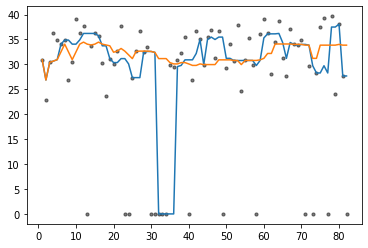

In [48]:
g = np.linspace(1, len(mb.MP), len(mb.MP))
for w in [5, 25]:
    plt.plot(g, mb.MP.rolling(w, min_periods = 1).median())

plt.scatter(g, mb.MP, alpha = 0.5, c = 'black', s = 10)


In [42]:

len(mb)

82